# Climate Anlysis and Exploration
March 26, 2019  
Scott McEachern

In [4]:
#-- Import Dependency

#- Charting
%matplotlib inline

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta


#- Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


# Reflect Tables into SQLAlchemy ORM

In [2]:
#- Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


#- Reflect the Tables
Base = automap_base()
Base.prepare(engine, reflect=True)


#- Display Tables found
Base.classes.keys()

['measurement', 'station']

In [3]:
#- Reference Tables
Measurement = Base.classes.measurement
Station = Base.classes.station


#- Create Session
session = Session(engine)

# Exploratory Climate Analysis

In [23]:
def printColumnNames(inspector, tableName):
    '''Prints column metadata
    
    Accepts : inspector (inspect) reference to sqlalchemy inspect used to get metadata
              tableName (str) name of table to get metadata
    '''
    
    print(f"--->  {tableName}")
    
    columns = inspector.get_columns(tableName)

    for column in columns:
        print(f"{column['name']}  {column['type']}")

In [24]:
#- View Columns: Measurement
inspector = inspect(engine)

printColumnNames(inspector, 'measurement')

print(" ")
printColumnNames(inspector, 'station')


--->  measurement
id  INTEGER
station  TEXT
date  TEXT
prcp  FLOAT
tobs  FLOAT
 
--->  station
id  INTEGER
station  TEXT
name  TEXT
latitude  FLOAT
longitude  FLOAT
elevation  FLOAT


In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


## 1.1 Precipitation Analysis
* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and prcp values.
* Load the query results into a Pandas DataFrame and set the index to the date column.
* Sort the DataFrame values by date.
* Plot the results using the DataFrame plot method.

In [55]:
#-- Determine Dates

#- Last date in dataset
lastDateString = session.query(func.max(Measurement.date)).scalar()


#- Convert to DateTime from String
lastDate = datetime.strptime(lastDateString, '%Y-%m-%d')


#- 12 Months from last date
startDate = lastDate - relativedelta(years=1)


#- Display Dates
print(f"Query start date: {startDate}")
print(f"Query end date: {lastDate}")

Query start date: 2016-08-23 00:00:00
Query end date: 2017-08-23 00:00:00


In [83]:
#-- Create DataFrame

#- Columns for dataframe
sel = [Measurement.date,
      Measurement.prcp]


#- Create List of Records
records = session.query(*sel).filter(Measurement.date.between(startDate, lastDate)).all()


#- Create DataFrame
dateColumn = 'Date'
prcpColumn = 'Precipitation'
precipitation_df = pd.DataFrame(x, columns=[dateColumn, prcpColumn])


#- Set Index on Date
precipitation_df.set_index(dateColumn, inplace=True)


#- Sort by Date
precipitation_df = precipitation_df.sort_values(by=[dateColumn])


#- Preview DataFrame
precipitation_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


In [62]:
#-- Summary Statistics
precipitation_df.describe()

,Prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [84]:
precipitation_df.count


<bound method DataFrame.count of             Precipitation
Date                     
2016-08-24           0.08
2016-08-24            NaN
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           2.15
2016-08-24           1.45
2016-08-24           1.22
2016-08-25           0.08
2016-08-25           0.00
2016-08-25           0.06
2016-08-25           0.00
2016-08-25           0.21
2016-08-25           0.11
2016-08-25           0.08
2016-08-26           0.02
2016-08-26           0.03
2016-08-26           0.01
2016-08-26           0.00
2016-08-26           0.04
2016-08-26           0.00
2016-08-27           0.12
2016-08-27           0.00
2016-08-27           0.18
2016-08-27            NaN
2016-08-27           0.00
2016-08-27           0.02
2016-08-28           0.14
2016-08-28           0.60
2016-08-28           0.14
2016-08-28           0.14
...                   ...
2017-08-16           0.42
2017-08-16           0.00
2017-08-16           0.07
2017-08-16           0.12
2017-

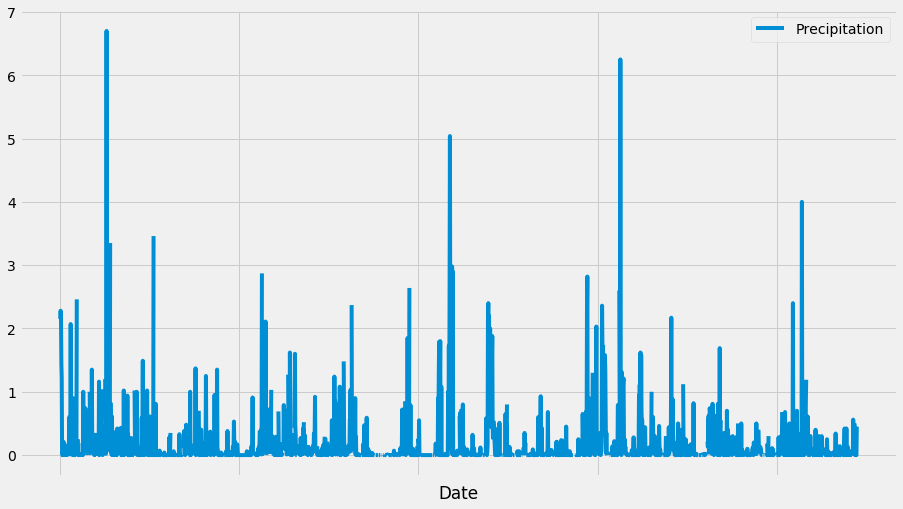

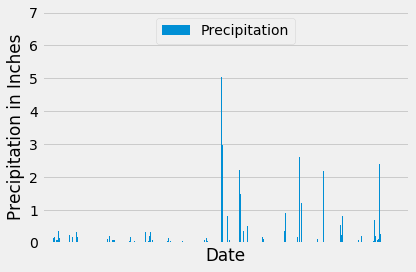

In [89]:
#-- Plot Results
precipitation_df.plot(figsize=(14, 8))

precipitation_df.plot.bar()


#- Chart Metadata
#plt.title(f"Precipitation in Hawaii; {startDate.strftime('%Y-%m-%d')} to {lastDate.strftime('%Y-%m-%d')}")

plt.xticks([])
plt.xlabel("Date")

plt.ylabel('Precipitation in Inches')



plt.legend()

plt.tight_layout()
plt.show()

In [77]:
print(f"the date is {lastDate.strftime('%Y-%m-%d')}")

the date is 2017-08-23


![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?


[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


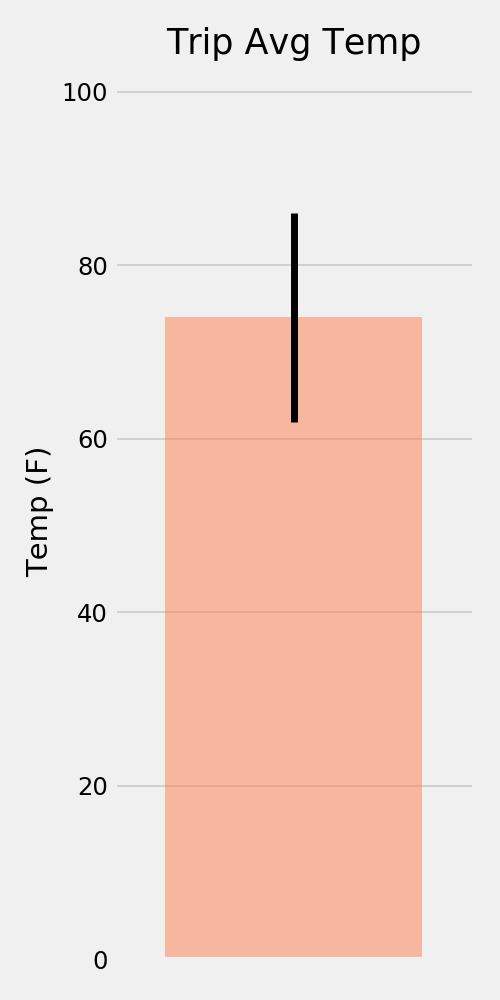

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


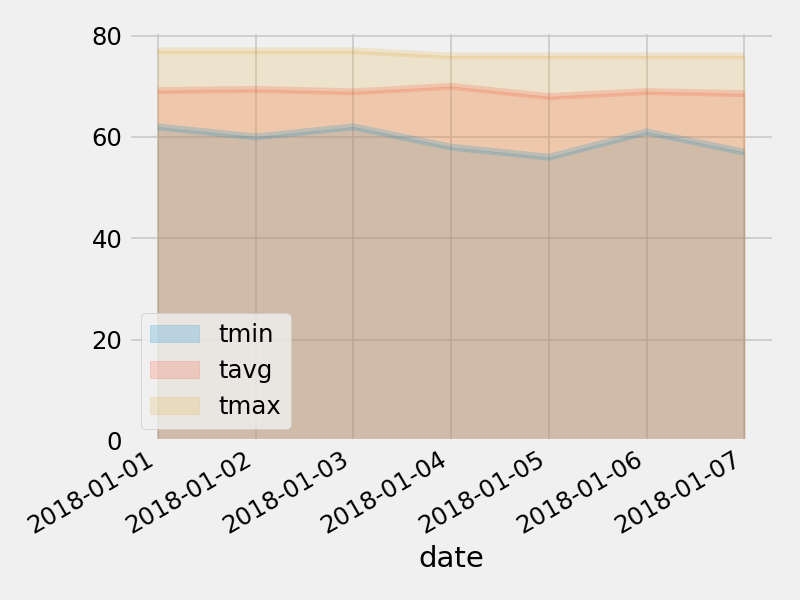

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
